In [1]:
import sys
import os
script_dir = os.getcwd() # coleata o diretorio do projeto atual
sys.path.append(script_dir)

Area de impoets

In [2]:
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage.feature import local_binary_pattern, hog


In [3]:
def carregar_imagens_pasta(base_path, target_size=(224, 224)):
    imagens = []
    labels = []
    
    # Percorre cada classe (pastas de classe)
    for classe in os.listdir(base_path):
        classe_path = os.path.join(base_path, classe, 'images')  # Caminho da pasta images
        
        # Verifica se é uma pasta válida
        if os.path.isdir(classe_path):
            # Percorre cada imagem dentro da pasta de imagens
            for img_name in os.listdir(classe_path):
                img_path = os.path.join(classe_path, img_name)
                
                # Carrega a imagem usando cv2
                img = cv2.imread(img_path)
                
                # Verifica se a imagem foi carregada corretamente
                if img is not None:
                    # Redimensiona a imagem
                    img_resized = cv2.resize(img, target_size)
                    
                    # Normaliza a imagem (opcional: normalize entre [0, 1])
                    img_normalized = img_resized / 255.0
                    
                    # Adiciona a imagem e o label (nome da classe) à lista
                    imagens.append(img_normalized)
                    labels.append(classe)
    
    return np.array(imagens), np.array(labels)


In [4]:
def create_MLP_model(input_dim, output_dim, dense_layers):
    model = models.Sequential()
    
    # Redimensionar os dados de entrada
    model.add(layers.Reshape((input_dim,), input_shape=(input_dim, 1)))
    
    model.add(layers.Dense(dense_layers[0], activation='relu'))

    for neurons in dense_layers[1:]:
        model.add(layers.Dense(neurons, activation='relu'))

    model.add(layers.Dense(output_dim, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def create_CNN_model(input, num_classes):
    model = Sequential([
    # Camada convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=input),
    MaxPooling2D((2, 2)),
    
    # Camada convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Camada convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Camada de flattening
    Flatten(),
    
    # Camada densa
    Dense(128, activation='relu'),
    
    # Camada de saída com softmax
    Dense(num_classes, activation='softmax')])

    # 3. Compilar o Modelo
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model


In [5]:
def coletor_Hu(imagem):
    imagem = (imagem * 255).astype(np.uint8)
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(imagem_cinza)
    saida = cv2.HuMoments(moments).flatten()
    return saida

def coletor_LBP(imagem, raio=1, pontos=8, metodo='uniform'):

    raio = 1  
    pontos = 8 * raio  

    imagem = (imagem * 255).astype(np.uint8)
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    
    lbp = local_binary_pattern(imagem_cinza, pontos, raio, metodo).flatten()
    
    return lbp

def coletor_HOG(imagem, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientacoes=9):
    imagem = (imagem * 255).astype(np.uint8)
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    
    hog_features, hog_image = hog(imagem_cinza, orientations=orientacoes, 
                                  pixels_per_cell=pixels_per_cell, 
                                  cells_per_block=cells_per_block, 
                                  block_norm='L2-Hys', visualize=True)
    
    return hog_features

def concatenar_inputs(Hu, LBP):
    return np.concatenate((Hu, LBP))

def cridaor_input_unico(imagem):
    hu_image = coletor_Hu(imagem)  # Extrair momentos de Hu
    LBP = coletor_LBP(imagem)  # Extrair LBP
    HOG = coletor_HOG(imagem)  # Extrair HOG
    
    saida = concatenar_inputs(np.concatenate((hu_image, LBP)), HOG)
    return saida

def produtor_MLP_Base(Base_criator):
    saida_base = []
      for x in Base_criator:
        saida_base.append(cridaor_input_unico(x))
    return saida_base


In [6]:
def mostrar_exemplos(imagens, labels, classes, num_exemplos=3):
    # Configura a visualização
    fig, axes = plt.subplots(len(classes), num_exemplos, figsize=(15, 5 * len(classes)))
    
    for i, classe in enumerate(classes):
        # Filtra imagens da classe atual
        indices = np.where(labels == classe)[0]
        exemplos = np.random.choice(indices, num_exemplos, replace=False)
        
        for j, idx in enumerate(exemplos):
            img = imagens[idx]
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
        
        # Adiciona o título no centro da coluna da classe
        ax_title = axes[i, num_exemplos // 2]
        ax_title.set_title(f'{classe}', fontsize=12, fontweight='bold', ha='center', va='center')
        ax_title.axis('off')
    
    plt.tight_layout()
    plt.show()

In [7]:
# Carregar imagens de treino
train_path = 'Data/Train'
X_train, y_train = carregar_imagens_pasta(train_path)

# Carregar imagens de validação
val_path = 'Data/Val'
X_val, y_val = carregar_imagens_pasta(val_path)


In [8]:
# Visualizar a quantidade de imagens carregadas
print(f"Total de imagens de treino: {len(X_train)}")
print(f"Total de imagens de validação: {len(X_val)}")
print(f"Total de classes: {set(y_val)}")

Total de imagens de treino: 4737
Total de imagens de validação: 512
Total de classes: {'Glioma', 'Pituitary', 'Meningioma', 'No Tumor'}


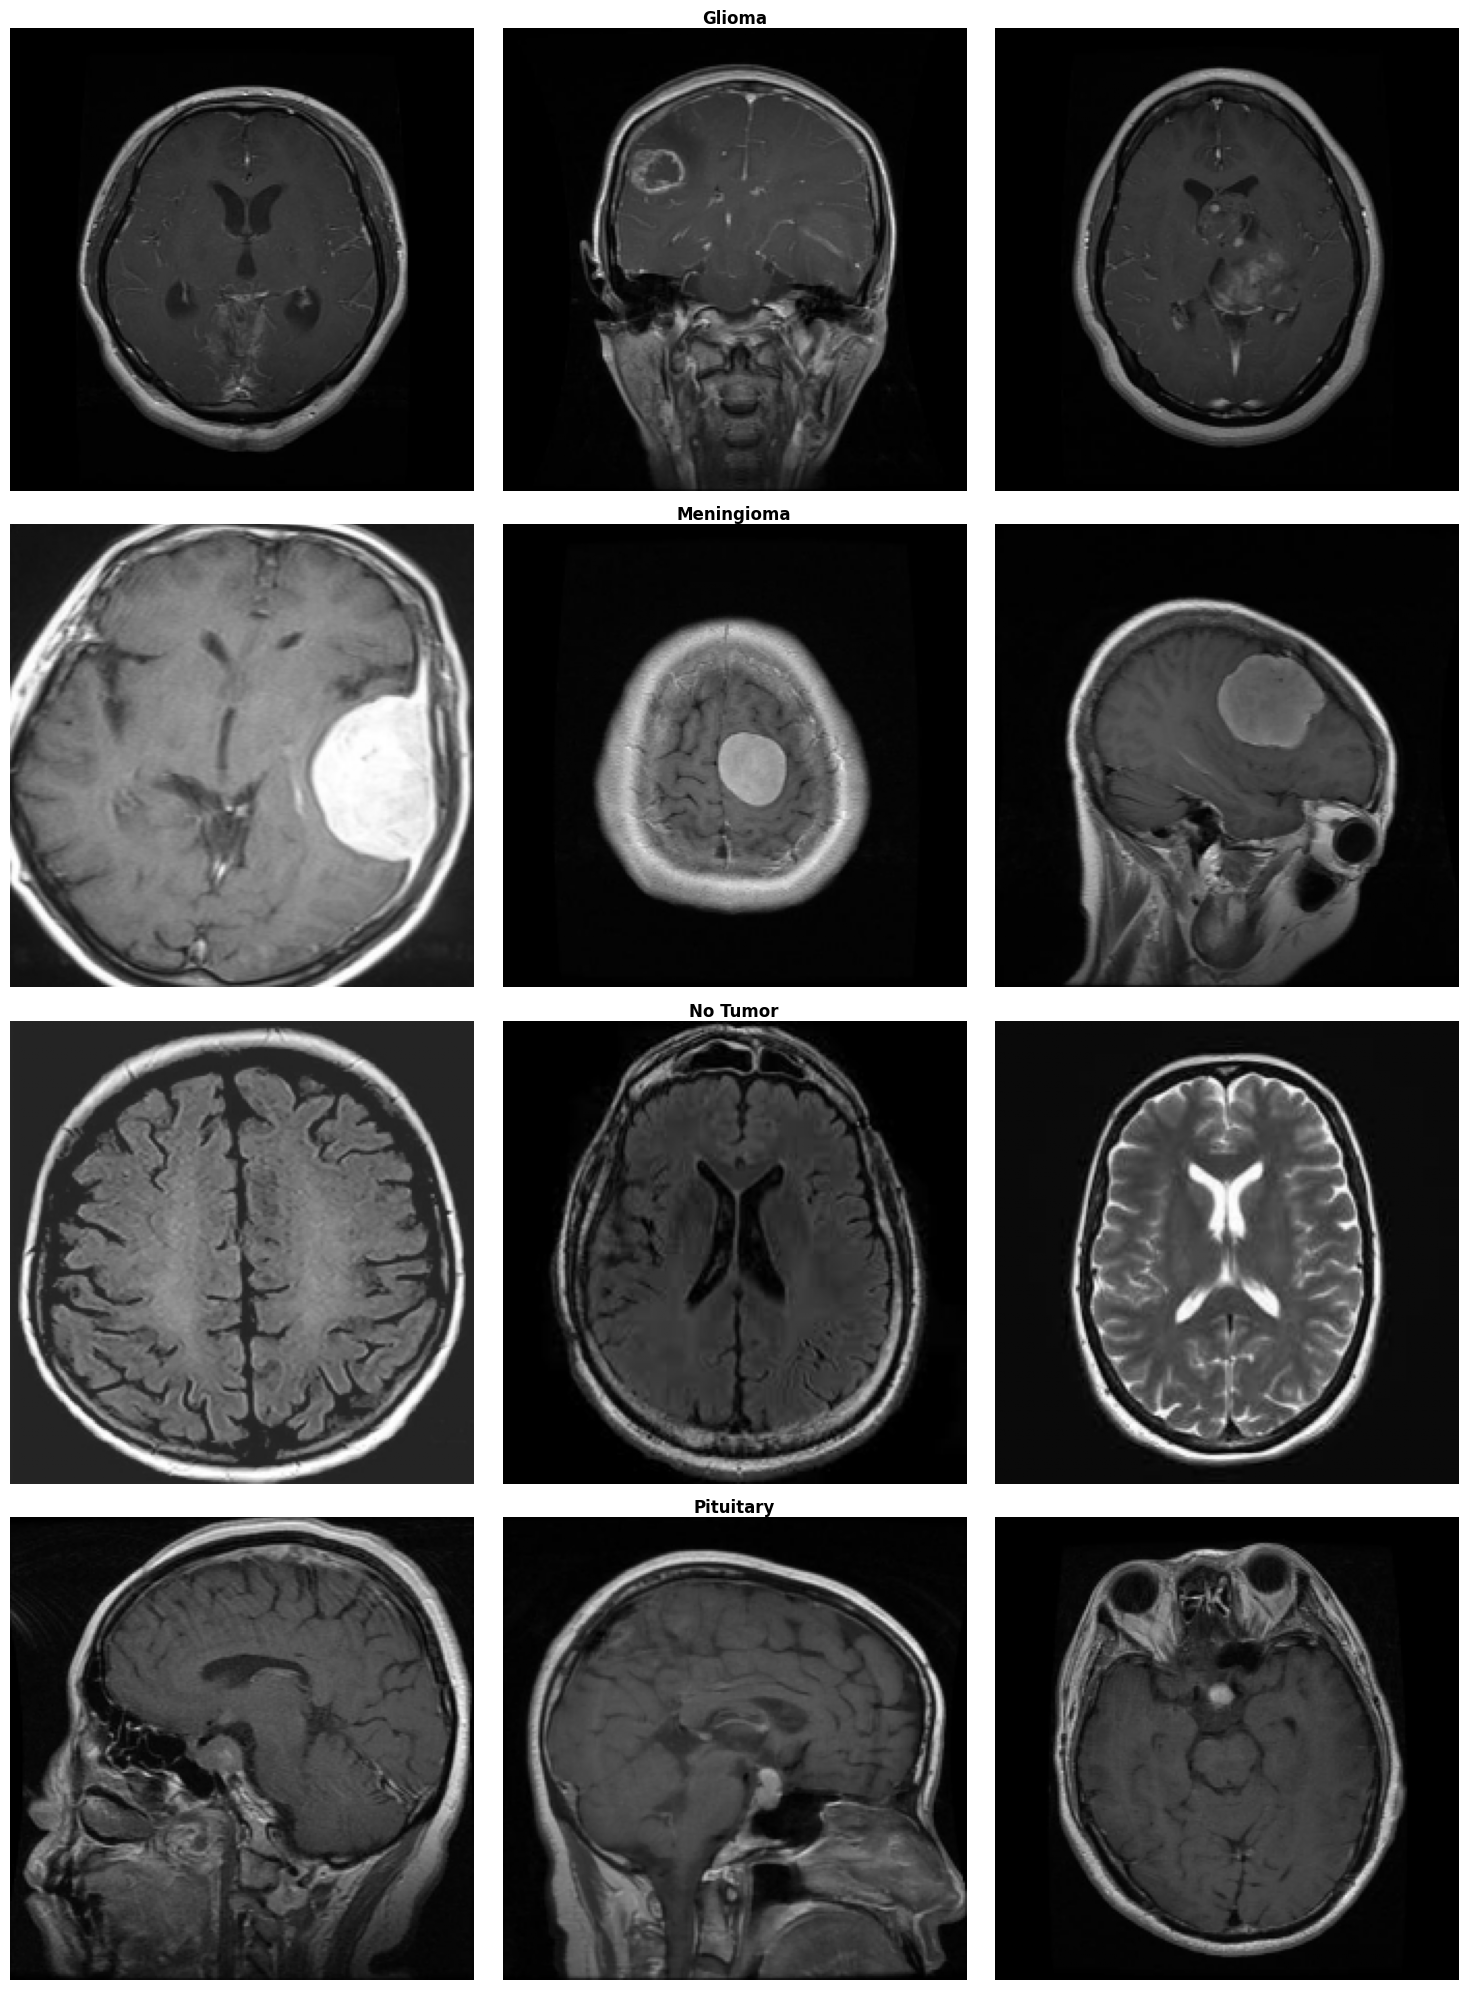

In [9]:
# Supondo que você já carregou as imagens e rótulos
# Classes devem ser as labels únicas presentes no seu dataset
classes = np.unique(y_train)
mostrar_exemplos(X_train, y_train, classes)


In [16]:
X_MLP_base_train = np.array(produtor_MLP_Base(X_train))
X_MLP_base_val = np.array(produtor_MLP_Base(X_val))

In [17]:
# Codificar os rótulos de classe em números
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [18]:
# One-hot encoding dos rótulos
num_classes = len(np.unique(y_train_encoded))
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=num_classes)

In [19]:
input_shape = X_train[0].shape
saida = num_classes

model_cnn = create_CNN_model(input_shape, saida)

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
input = len(X_MLP_base_train[0])
saida = num_classes
dense_layers = [64, 32, 64]

model_mlp = create_MLP_model(input, saida, dense_layers)

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
history_mlp = model_mlp.fit(
    X_MLP_base_train, y_train_one_hot,
    epochs=20,  # Número de épocas, ajuste conforme necessário
    batch_size=32,
    validation_data=(X_MLP_base_val, y_val_one_hot)
)

val_loss, val_accuracy = model_mlp.evaluate(X_MLP_base_val, y_val_one_hot)
print(f'Perda de Validação: {val_loss}')
print(f'Precisão de Validação: {val_accuracy}')

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.3830 - loss: 16.6618 - val_accuracy: 0.1953 - val_loss: 16.0448
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5030 - loss: 6.5392 - val_accuracy: 0.6582 - val_loss: 1.5752
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7630 - loss: 0.8307 - val_accuracy: 0.6348 - val_loss: 1.6820
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7866 - loss: 0.6690 - val_accuracy: 0.5508 - val_loss: 1.5562
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7261 - loss: 1.1665 - val_accuracy: 0.8047 - val_loss: 0.8215
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8929 - loss: 0.3027 - val_accuracy: 0.6348 - val_loss: 1.5979
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9355 - loss: 0.1800 - val_accuracy: 0.8457 - val_loss: 0.4477
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8813 - loss: 0.4001 - val_ac

In [20]:
history_cnn = model_cnn.fit(
    X_train, y_train_one_hot,
    epochs=20,  # Número de épocas, ajuste conforme necessário
    batch_size=32,
    validation_data=(X_val, y_val_one_hot)
)

val_loss, val_accuracy = model_cnn.evaluate(X_val, y_val_one_hot)
print(f'Perda de Validação: {val_loss}')
print(f'Precisão de Validação: {val_accuracy}')


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 76s 490ms/step - accuracy: 0.5855 - loss: 0.9952 - val_accuracy: 0.7969 - val_loss: 0.5490
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 72s 484ms/step - accuracy: 0.8572 - loss: 0.3663 - val_accuracy: 0.9004 - val_loss: 0.2773
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 75s 504ms/step - accuracy: 0.9371 - loss: 0.1602 - val_accuracy: 0.9238 - val_loss: 0.2484
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 74s 496ms/step - accuracy: 0.9756 - loss: 0.0736 - val_accuracy: 0.9043 - val_loss: 0.3181
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 74s 495ms/step - accuracy: 0.9801 - loss: 0.0561 - val_accuracy: 0.9297 - val_loss: 0.2622
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 73s 489ms/step - accuracy: 0.9900 - loss: 0.0318 - val_accuracy: 0.9336 - val_loss: 0.3083
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 73s 487ms/step - accuracy: 0.9947 - loss: 0.0259 - val_accuracy: 0.9395 - val_loss: 0.2307
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 73s 490ms/step - accuracy: 0.9954 - loss: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


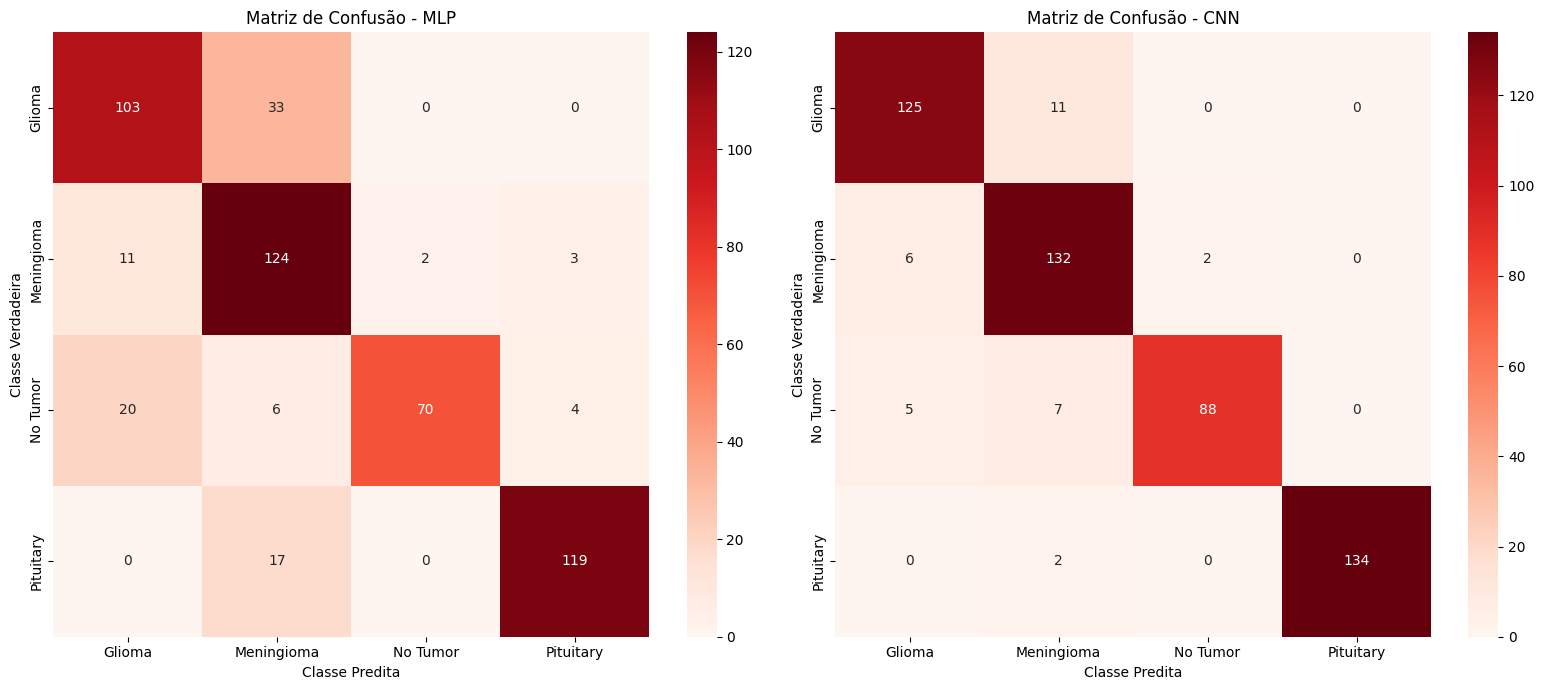

In [21]:
y_pred_mlp = model_mlp.predict(X_MLP_base_val)
y_pred_classes_mlp = np.argmax(y_pred_mlp, axis=1)

y_pred_cnn = model_cnn.predict(X_val)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

y_true = np.argmax(y_val_one_hot, axis=1)

conf_matrix_mlp = confusion_matrix(y_true, y_pred_classes_mlp)
conf_matrix_cnn = confusion_matrix(y_true, y_pred_classes_cnn)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set_title('Matriz de Confusão - MLP')
axes[0].set_xlabel('Classe Predita')
axes[0].set_ylabel('Classe Verdadeira')

sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[1].set_title('Matriz de Confusão - CNN')
axes[1].set_xlabel('Classe Predita')
axes[1].set_ylabel('Classe Verdadeira')

plt.tight_layout()
plt.show()

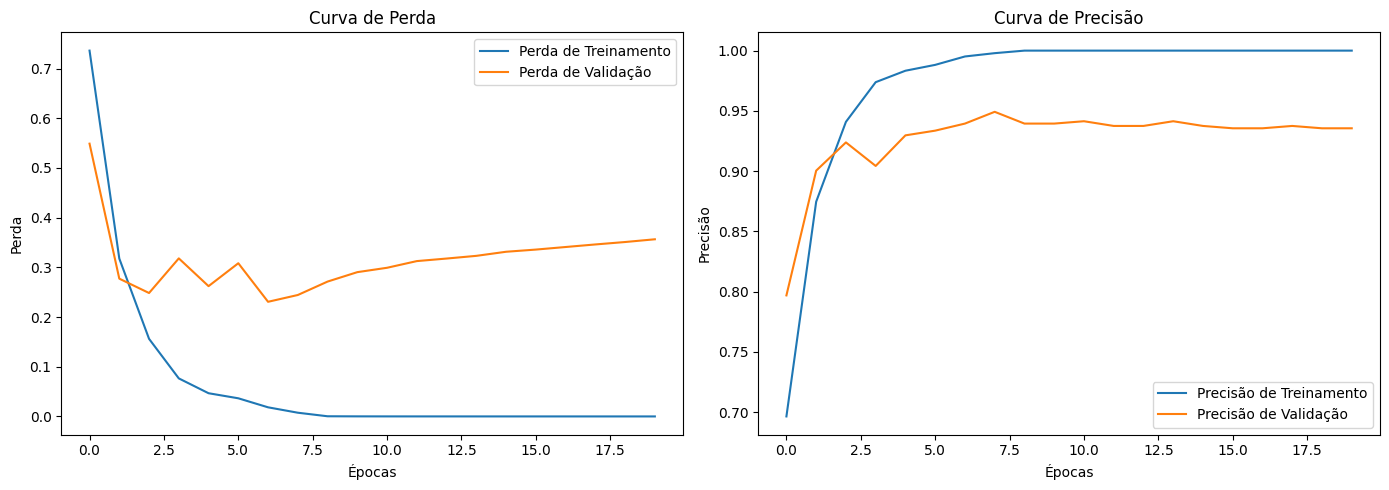

In [22]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perda de Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Perda de Validação')
plt.title('Curva de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Precisão de Treinamento')
plt.plot(history_cnn.history['val_accuracy'], label='Precisão de Validação')
plt.title('Curva de Precisão')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

plt.tight_layout()
plt.show()


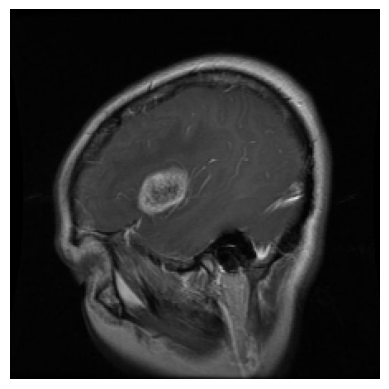

In [21]:
Imagem_pika = X_train[1]
Imagem_pika = (Imagem_pika * 255).astype(np.uint8)

plt.imshow(Imagem_pika)
plt.axis('off')  # Oculta os eixos
plt.show()

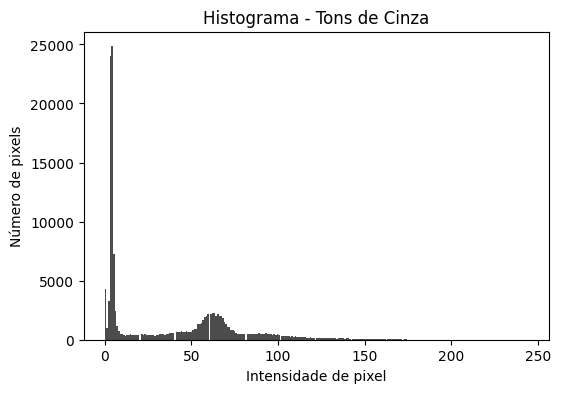

In [22]:
plt.figure(figsize=(6, 4))
plt.hist(Imagem_pika.ravel(), bins=256, color='black', alpha=0.7)
plt.title('Histograma - Tons de Cinza')
plt.xlabel('Intensidade de pixel')
plt.ylabel('Número de pixels')
plt.show()

In [23]:
def metodologia_pre_tc_eh(imagem_usada):
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    imagem_equalizada = cv2.equalizeHist(imagem_usada)
    imagem_brilho = cv2.convertScaleAbs(imagem_usada, alpha=0.5, beta=0)
    return imagem_brilho

def metodologia_pre_tc_bn(imagem_usada):
    limiar = 90
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    _, binary_img = cv2.threshold(imagem_usada, limiar, 255, cv2.THRESH_BINARY)
    return binary_img

def metodologia_pre_tc_gus_bn(imagem_usada):
    limiar = 90
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(imagem_usada, (5, 5), 0)
    _, binary_img = cv2.threshold(blurred_img, limiar, 255, cv2.THRESH_BINARY)
    return binary_img

def metodologia_pre_tc_eh_bn(imagem_usada):
    limiar = 220
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    imagem_equalizada = cv2.equalizeHist(imagem_usada)
    _, binary_img = cv2.threshold(imagem_equalizada, limiar, 255, cv2.THRESH_BINARY)
    return binary_img

def metodologia_pre_tc_gus_bn_cpc(imagem_usada):
    limiar = 100
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(imagem_usada, (5, 5), 0)
    _, binary_img = cv2.threshold(blurred_img, limiar, 255, cv2.THRESH_BINARY)
    binary_img = binary_img.astype(np.uint8)

    _, labels_im = cv2.connectedComponents(binary_img)

    label_hue = np.uint8(179 * labels_im / np.max(labels_im))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0  # Definir fundo como preto

    return labeled_img

def metodologia_pre_tc_mediana_normalizacao_conexo(imagem_usada):
    limiar = 120
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    imagem_mediana = cv2.medianBlur(imagem_usada, 5)
    imagem_normalizada = cv2.normalize(imagem_mediana, None, 0, 255, cv2.NORM_MINMAX)
    _, binary_img = cv2.threshold(imagem_normalizada, limiar, 255, cv2.THRESH_BINARY)

    _, labels_im = cv2.connectedComponents(binary_img)

    label_hue = np.uint8(179 * labels_im / np.max(labels_im))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0  # Definir fundo como preto

    return labeled_img

def metodologia_pre_tc_gus_bn_lp_cpc(imagem_usada):
    limiar = 100
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(imagem_usada, (5, 5), 0)
    _, binary_img = cv2.threshold(blurred_img, limiar, 255, cv2.THRESH_BINARY)
    binary_img = binary_img.astype(np.uint8)

    _, labels_im = cv2.connectedComponents(binary_img)

    # Normalizar os rótulos para exibir como imagem (escala de cores)
    label_hue = np.uint8(179 * labels_im / np.max(labels_im))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converter para BGR e aplicar a máscara binária
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0  # Definir fundo como preto

    laplacian = cv2.Laplacian(labeled_img, cv2.CV_8U)

    return laplacian


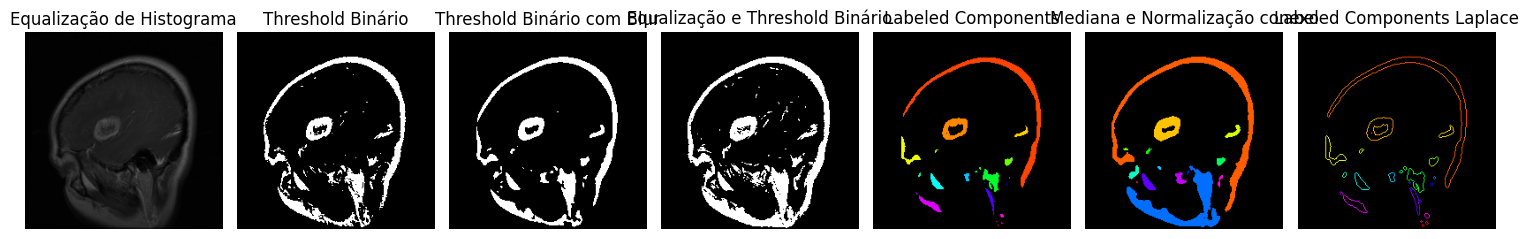

In [24]:
imagens = {
    'Equalização de Histograma': metodologia_pre_tc_eh(Imagem_pika),
    'Threshold Binário': metodologia_pre_tc_bn(Imagem_pika),
    'Threshold Binário com Blur': metodologia_pre_tc_gus_bn(Imagem_pika),
    'Equalização e Threshold Binário': metodologia_pre_tc_eh_bn(Imagem_pika),
    'Labeled Components': metodologia_pre_tc_gus_bn_cpc(Imagem_pika),
    'Mediana e Normalização conexo': metodologia_pre_tc_mediana_normalizacao_conexo(Imagem_pika),
    'Labeled Components Laplace': metodologia_pre_tc_gus_bn_lp_cpc(Imagem_pika)
}

num_metodos = len(imagens)
fig, axes = plt.subplots(1, num_metodos, figsize=(15, 5))

for ax, (nome, img) in zip(axes, imagens.items()):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(nome)
    ax.axis('off')  

plt.tight_layout()
plt.show()

In [ ]:
for nome, conteudo in imagens.items():
    for image in X_train:
        imagem_final = conteudo(image)
        if len(imagem_final.shape) == 2:
            imagem_final = cv2.cvtColor(imagem_final, cv2.COLOR_GRAY2RGB)

    for image in X_val:
        imagem_final = conteudo(image)
        if len(imagem_final.shape) == 2:
            imagem_final = cv2.cvtColor(imagem_final, cv2.COLOR_GRAY2RGB)
            

    X_MLP_base_train = np.array(produtor_MLP_Base(X_train))
    X_MLP_base_val = np.array(produtor_MLP_Base(X_val))

In [21]:
# Salvar o modelo MLP
model_mlp.save('modelo_mlp.h5')

# Salvar o modelo CNN
model_cnn.save('modelo_cnn.h5')

In [24]:
# Salvar o histórico de treinamento do MLP
with open('historico_treinamento_mlp.json', 'w') as f:
    json.dump(history_mlp.history, f)

# Salvar o histórico de treinamento do CNN
with open('historico_treinamento_cnn.json', 'w') as f:
    json.dump(history_cnn.history, f)


In [25]:
# Carregar o histórico de treinamento do MLP
with open('historico_treinamento_mlp.json', 'r') as f:
    historico_mlp_carregado = json.load(f)

# Carregar o histórico de treinamento do CNN
with open('historico_treinamento_cnn.json', 'r') as f:
    historico_cnn_carregado = json.load(f)
